# Cleaning Textual Data

# Goal

The goal of this script is to examine and ultimately test NLP cleaning mechanisms to create a cleaned textual dataset on which to implement Latent Dirilicht Allocation.  In this notebook I will outline XX major steps. Data cleaning is one of the most difficult aspects of any machine learning/artificial intelligence because it requires many subjective/human choices on what consititutes "clean" data.  Additonally, in cases where the dataset can be large, occurrences of "bad" data increases and it can be difficult to catch edge cases.  In this notebook, I will attempt to clean the data using the following steps.  

# Steps
1. Load in a textual model which will be the basis of our training data.
2. Load in the textual data, which are the abstracts along with other fields (including arXiv_ID, Authors, arXiv, Categories, etc).  We will extract the textual data, since we are only cleaning the data.  
3. Using standard NLP techniques tokenize the textual data, lemmatize the text and remove stopwords.  This is done by preselecting from already established text corpi and manually implement domain specific terms as stop words.  Then remove those stopwords.  
6. Remove "unnecessary/useless" text which should not impact topics.  These words will unnecessarily increase the size of the corpus, while other textual data can be more indicative of the tone of the data.  This includes removing mathematical text, URLs, terms which include tildes and slashes and other LaTex sequences.
7. From the remaining corpus, we want to replace similar occurrences of words that did not captured in the lemmatization process.  For example if the **Base Word** is observe, we want to replace instances of *Derived Words* like observed, observationally, observational, etc. with observe. 

In [63]:
# Importing standard Python Packages here 
import sqlite3
from tqdm import tqdm

import numpy as np
import scipy as sp 
import pandas as pd 

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt

In [65]:
import spacy
import re
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.stem import SnowballStemmer


# Load scientific/biomedical model if needed
# nlp = spacy.load("en_core_sci_sm")  # if using scispaCy
_nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # faster for our use
_WORDS = list(_nlp.vocab.strings) 
_stemmer = SnowballStemmer("english")

model = SentenceTransformer('allenai/scibert_scivocab_uncased')

words = ["resolution", "revolution", "galaxy", "galaxies"]

def preprocessTextPass1(text):
    
    # Convert the abstract to lowercase
    text = text.lower()

    # Remove URLs, LaTeX math, inline citations, and other nonp-ascii texts
    text= re.sub(r"\d+", "", text)
    text = re.sub(r"\$.*?\$", "", text)  # remove LaTeX math and numbers
    text = re.sub(r"\[.*?\]|\(.*?et al\.\)", "", text)  # remove inline citations

    # Define a pattern
    latex_pattern = re.compile(r'''
    (\\[a-zA-Z]+\{[^}]*\})            | # commands with arguments e.g. \citep{...}
    (\\[a-zA-Z]+)                     | # lone LaTeX commands e.g. \msun, \deg
    (\^\{[^}]*\})                     | # superscript math fragments e.g. ^{x}
    (\^\S+)                           | # other caret superscripts
    (\,\\~?[a-zA-Z]+)                 | # unit-like sequences: \,km, \,erg
    (\~\\?[a-zA-Z]+)                  | # tilde-prefixed units like ~\deg
    (\/\\?[a-zA-Z]+)                  | # slash-prefixed like /\beta_i
    (\{\\?[a-zA-Z]+\})                | # like {\deg}
    (\.\{\\?[a-zA-Z]+\})              | # .{\deg}
    (a\([a-z]+\)=\S*)                 | # a(li)=...
    (\\cite\w*\{[^}]*\})             | # citations
    (\\emph\{[^}]*\})                | # \emph{text}
    (\^\S*)                          | # leftover superscripts
    (\\[a-zA-Z]+\\?)                 | # generic backslash sequences like \kms\
    (\^\\?[a-zA-Z_]+)                | # ^alpha, ^m_sun
    (\{\\?[a-zA-Z]+\})               | # more embedded latex
    ''', re.VERBOSE)
    text = re.sub(latex_pattern, "", text)
    
    # Replace hyphens with spaces
    text = text.replace('-', '')

    # Combine NLTK and sklearn stopwords
    STOPWORDS = set(stopwords.words("english")).union(ENGLISH_STOP_WORDS)
    
    # Custom stopwords for astrophysics
    CUSTOM_STOPWORDS = set([
        "et", "al", "figure", "using", "based", "data", "datum", "analysis",
        "result", "results", "show", "use", "used", "paper", "new", "present", "study", "scientific",
        "tool", "dataset", "mass", "alpha", "beta", "article", "start", "stark", "end", "like"
    ])
    STOPWORDS.update(CUSTOM_STOPWORDS)
    
    # Tokenize + lemmatize with SpaCy
    doc = _nlp(text)
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token.like_num:
            continue
        if token.lemma_ in STOPWORDS or token.lemma_ in string.punctuation:
            continue
        if len(token.lemma_) < 4:
            continue
        token = token.lemma_
        tokens.append(token)

    return " ".join(tokens)

def preprocessTextPass2(text, _CANONICAL_MAP):
    
    # Convert the abstract to lowercase
    text = text.lower()

    # Remove URLs, LaTeX math, inline citations, and other nonp-ascii texts
    text= re.sub(r"\d+", "", text)
    text = re.sub(r"\$.*?\$", "", text)  # remove LaTeX math and numbers
    text = re.sub(r"\[.*?\]|\(.*?et al\.\)", "", text)  # remove inline citations

    # Define a pattern
    latex_pattern = re.compile(r'''
    (\\[a-zA-Z]+\{[^}]*\})            | # commands with arguments e.g. \citep{...}
    (\\[a-zA-Z]+)                     | # lone LaTeX commands e.g. \msun, \deg
    (\^\{[^}]*\})                     | # superscript math fragments e.g. ^{x}
    (\^\S+)                           | # other caret superscripts
    (\,\\~?[a-zA-Z]+)                 | # unit-like sequences: \,km, \,erg
    (\~\\?[a-zA-Z]+)                  | # tilde-prefixed units like ~\deg
    (\/\\?[a-zA-Z]+)                  | # slash-prefixed like /\beta_i
    (\{\\?[a-zA-Z]+\})                | # like {\deg}
    (\.\{\\?[a-zA-Z]+\})              | # .{\deg}
    (a\([a-z]+\)=\S*)                 | # a(li)=...
    (\\cite\w*\{[^}]*\})             | # citations
    (\\emph\{[^}]*\})                | # \emph{text}
    (\^\S*)                          | # leftover superscripts
    (\\[a-zA-Z]+\\?)                 | # generic backslash sequences like \kms\
    (\^\\?[a-zA-Z_]+)                | # ^alpha, ^m_sun
    (\{\\?[a-zA-Z]+\})               | # more embedded latex
    ''', re.VERBOSE)
    text = re.sub(latex_pattern, " ", text)
    
    # Replace hyphens with spaces
    text = text.replace('-', ' ')

    # Combine NLTK and sklearn stopwords
    STOPWORDS = set(stopwords.words("english")).union(ENGLISH_STOP_WORDS)
    
    # Custom stopwords for astrophysics
    CUSTOM_STOPWORDS = set([
        "et", "al", "figure", "using", "based", "data", "datum", "analysis",
        "result", "results", "show", "use", "used", "paper", "new", "present", "study", "scientific",
        "tool", "dataset", "mass", "alpha", "beta", "article",
    ])
    STOPWORDS.update(CUSTOM_STOPWORDS)
    
    # Tokenize + lemmatize with SpaCy
    doc = _nlp(text)
    tokens = []
    for token in doc:
        if token in _CANONICAL_MAP.keys():
            print(f"We found a word in keys: {_}, replacing with {_CANONICAL_MAP[_]}")
            token = _CANONICAL_MAP[_]
            continue
        if token.is_stop or token.is_punct or token.like_num:
            continue
        if token.lemma_ in STOPWORDS or token.lemma_ in string.punctuation:
            continue
        if len(token.lemma_) < 4:
            continue
        tokens.append(token.lemma_)

    return " ".join(tokens)

No sentence-transformers model found with name allenai/scibert_scivocab_uncased. Creating a new one with mean pooling.


In [66]:
%cd ../arXiv_MetadataExtraction

/Users/nakulgangolli/Desktop/arXiv_Reader/arXiv_MetadataExtraction


/opt/anaconda3/envs/BERTopic_Env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## SQL Database Extraction 

In [67]:
# Connect to an existing database or create a new one if it doesn't exist
con = sqlite3.connect("arxiv_astro.db")

# Create a cursor object
cur = con.cursor()

#Extract the list of databases available
cur.execute("PRAGMA database_list;")

#Read in all the different databases 
databases = cur.fetchall()
for db in databases: print(f"Database Name: {db[1]}, Path: {db[2]}")

# Reading from arxiv_papers
query = "SELECT * FROM arxiv_papers" 

Database Name: main, Path: /Users/nakulgangolli/Desktop/arXiv_Reader/arXiv_MetadataExtraction/arxiv_astro.db


## Structure

The cell below extracts the fields that are important for the textual data reduction.  In the cell below I will extract and transform the textual data, however at the end I will want to obtain a database which will include the following columns: 

1. arXiv ID Number
2. Title of Article
3. Abstract
4. Authors
5. arXiv Categories
6. Year Published
7. Month Published
8. Number of Authors
9. Cleaned Abstract

The **Cleaned Abstract** will be the resultant textual data after all the data has undergone the data reduction pipeline mentioned previously.

We will first begin with extracting all the other relevant data columns (1-8). 

In [68]:
query = "SELECT *, STRFTIME('%Y', published) AS Year, STRFTIME('%m', published) AS Month, "+\
        "LENGTH(authors) - LENGTH(REPLACE(authors, ',', ''))+1 as NumAuthors FROM arxiv_papers"
df = pd.read_sql_query(query, con)
df.drop(columns=['published', 'updated', 'citations', 'keywords', 'external_json'], inplace=True)

In [69]:
print(f"Columns we currently have in our output dataframe: {df.columns}")

Columns we currently have in our output dataframe: Index(['arXiv_ID', 'title', 'abstract', 'authors', 'categories', 'Year',
       'Month', 'NumAuthors'],
      dtype='object')


## Preprocessing Textual Data 

In the cell below, I am implementing the preprocessing step that tokenizes the text and from there removes the stopwords, lemmatizes the known words, and removes any domain specific terminology and LaTex specific terms. 

In [70]:
import time 
start_time = time.time()
ABSTRACT_LIST = df['abstract'].values
CLEANED_ABSTRACT_LIST = list(map(lambda _ABSTRACT: preprocessTextPass1(_ABSTRACT), ABSTRACT_LIST))
print(f"Time to preprocess abstract text: {time.time()-start_time:1.4f}")

Time to preprocess abstract text: 104.1853


## Vocabulary 

In the next 2 cells, I am extracting the unique words,  

I have selected words which have occurred $>3$ times in the entire corpus, as single words will provide very little context and could be observed as noise (misspellings which have occurred once).  I have implemented manual tests that show that applying a cut of 3 occurrences consistently yielded the best results.

In [71]:
# Extracting all the words into a single list to check number of occurrences 
vocabulary = {}
for ABSTRACT in tqdm(CLEANED_ABSTRACT_LIST):
    tokenized_abstract = ABSTRACT.split(' ')
    for _ in tokenized_abstract:
        if _ not in vocabulary.keys():
            vocabulary[_] = 1 
        else: 
            vocabulary[_] += 1 
    # vocabulary = np.concatenate([vocabulary, tokenized_abstract])
print(vocabulary)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5610/5610 [00:00<00:00, 43095.16it/s]

{'venga': 3, 'largescale': 214, 'extragalactic': 360, 'survey': 2469, 'bulge': 272, 'large': 2479, 'outer': 180, 'disk': 997, 'nearby': 394, 'normal': 166, 'spiral': 141, 'galaxy': 4397, 'target': 449, 'choose': 71, 'span': 209, 'wide': 512, 'range': 1527, 'hubble': 247, 'type': 1076, 'star': 6256, 'formation': 1552, 'activity': 250, 'morphology': 238, 'inclination': 115, 'time': 2312, 'vast': 65, 'available': 619, 'multiwavelength': 190, 'coverage': 207, 'faruv': 10, 'midir': 63, 'mapping': 104, 'provide': 1988, 'stellar': 2702, 'kinematic': 201, 'chemical': 428, 'abundance': 701, 'density': 1416, 'ionization': 151, 'state': 406, 'dust': 845, 'extinction': 335, 'population': 1293, 'uniqueness': 3, 'virusp': 1, 'field': 2213, 'view': 339, 'permit': 43, 'perform': 775, 'allow': 931, 'correlate': 164, 'important': 546, 'quantity': 145, 'different': 1311, 'environment': 477, 'galactic': 1761, 'conduction': 29, 'number': 1033, 'structure': 977, 'assembly': 52, 'feedback': 437, 'analyze': 2

In [93]:
# Get all the unique words and count their occurrences in the text
vocabulary_unique, occurrences = np.array(list(vocabulary.keys())), np.array(list(vocabulary.values())) # np.unique(vocabulary, return_counts=True)
print(vocabulary_unique[:100], np.shape(occurrences))
print(max(occurrences), min(occurrences))

# Sorting the lists by the number of occurrences of each word, and selecting 
# only those words which  occur more than N times.  However one could vary NCUT 
# which dictates the number of times a word must occur or it will be cut. 
NCUT = 10
SORTED = np.argsort(occurrences)[::-1]
vocabulary_unique, occurrences = vocabulary_unique[SORTED], occurrences[SORTED]
vocabulary_limitCut = vocabulary_unique[np.where(occurrences > NCUT)[0]]
occurrences_limitCut = occurrences[np.where(occurrences > NCUT)[0]]
vocabulary_OccurrenceDict = {word: num for word, num in zip(vocabulary_limitCut, occurrences_limitCut)}

print(f"Number of Unique Words: {len(vocabulary_unique)} \t Number of Words that occur >{NCUT} times: {len(vocabulary_limitCut)}")
# for word in vocabulary_unique: print(word)

['venga' 'largescale' 'extragalactic' 'survey' 'bulge' 'large' 'outer'
 'disk' 'nearby' 'normal' 'spiral' 'galaxy' 'target' 'choose' 'span'
 'wide' 'range' 'hubble' 'type' 'star' 'formation' 'activity' 'morphology'
 'inclination' 'time' 'vast' 'available' 'multiwavelength' 'coverage'
 'faruv' 'midir' 'mapping' 'provide' 'stellar' 'kinematic' 'chemical'
 'abundance' 'density' 'ionization' 'state' 'dust' 'extinction'
 'population' 'uniqueness' 'virusp' 'field' 'view' 'permit' 'perform'
 'allow' 'correlate' 'important' 'quantity' 'different' 'environment'
 'galactic' 'conduction' 'number' 'structure' 'assembly' 'feedback'
 'analyze' 'rise' 'fall' 'supernova' 'light' 'curve' 'discover' 'sdssii'
 'kcorrecte' 'rest' 'frame' 'band' 'small' 'dispersion' 'portion'
 'compare' 'decline' 'qualitative' 'agreement' 'computer' 'model'
 'predict' 'variation' 'radioactive' 'nickel' 'yield' 'impact' 'spread'
 'rate' 'difference' 'property' 'suggest' 'single' 'stretch' 'correction'
 'phase' 'properly' 's

##  Calculating the Jaccard Similarity Distances

The purpose of these next few cells is to group words that are very similar to each other.  The purpose of this cleaning method is to ensure that words that are highly similar do not ultimately lead to disparate groups simply because of tenses, or even worse misspellings.  For example for the word "galaxy" we can have derivative words like galaxies, galactic, or galxie (a misspelling).  While each of these are their own words, they are clearly related. 

To this end, I am going to measure the similarity of words using the Jaccard similarity.  The Jaccard Similarity is used for gauging the similarity and diversity of sample sets. It is defined in general as taking the ratio of two sizes, the intersection size divided by the union size, also called intersection over union.

$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$

I will implement this metric by deriving the 3-gram of each word (3 letters from a word), and calculating the Jaccard similairty between the 3 grams of Word 1 (*w1*) and Word 2 (*w2*) 

###  Getting the n-grams

In [94]:
NGRAM = 2

def get_ngrams(word, n=3):
    word = f"#{word}#"  # padding to preserve start/end
    return set([word[i:i+n] for i in range(len(word)-n+1)])

word_ngrams = {w: get_ngrams(w, NGRAM) for w in vocabulary_limitCut}

###  Jaccard Similarity

I found that a Jaccard similarity score of 0.65 worked optimally for extracting similar words.  

In [101]:
from itertools import combinations

def calc_JaccardSimilarity(a, b):
    return len(a & b) / len(a | b) if len(a | b) > 0 else 0

jacSim_THRESHOLD = 0.5
cosSim_THRESHOLD = 0.90
SIMILAR_PAIRS = []
count = 0

embeddings = model.encode(vocabulary_limitCut)
similarity_matrix = cosine_similarity(embeddings)
print(len(vocabulary_limitCut), np.shape(similarity_matrix))


for w1, w2 in combinations(np.arange(len(vocabulary_limitCut)), 2):
    word1, word2 = vocabulary_limitCut[w1], vocabulary_limitCut[w2]
    # print(f"Iteration: {count}")
    count += 1
    if 'mission' in word1 or 'mission' in word2: 
        continue
    # if 'galax' in w1 and 'galax' in w2:
    #     SIMILAR_PAIRS.append(('galaxy', w1))
    #     SIMILAR_PAIRS.append(('galaxy', w2))
    #     print("BOTH", w1, w2, SIMILAR_PAIRS[-1:])
    #     continue
    # elif 'galax' in w1:
    #     SIMILAR_PAIRS.append(('galaxy', w1))
    #     print("W1", w1, w2, SIMILAR_PAIRS[-1:])
    #     continue
    # elif 'galax' in w2:
    #     SIMILAR_PAIRS.append(('galaxy', w2))
    #     print("W2", w1, w2, SIMILAR_PAIRS[-1:])
    #     continue
    
    # Optional: quick length filter
    if abs(len(word1) - len(word2)) > 4:
        continue

    jacSim = calc_JaccardSimilarity(word_ngrams[word1], word_ngrams[word2])
    # print(f"Word 1 ID: %d for %s \t Word 2 ID: %d for %s \t Cos Sim: %1.4f \t Jac Sim: %1.4f"%(w1, word1, w2, word2, similarity_matrix[w1][w2], jacSim))
    if (jacSim >= jacSim_THRESHOLD and similarity_matrix[w1][w2] >= cosSim_THRESHOLD) or (jacSim >= jacSim_THRESHOLD >= 0.9):
        # print(f"Found similar pairs: {w1} and {w2} w/ score {sim}")
        SIMILAR_PAIRS.append((word1, word2))

3839 (3839, 3839)


In [102]:
print(f"Number of Similar Pairs {len(SIMILAR_PAIRS)}")
# for _ in SIMILAR_PAIRS: print(_)

Number of Similar Pairs 246


## Graph

We will build a network here, which connects all the words for which we found similarities.  This is done by finding the connected components and building clusters.  I then choose the original word by selecting out the shortest word in the cluster.  While this may not be the optimal choice of selecting the **Base Word**, it appears that many *Derived Words* are extensions **Base Word**. I will then extract the common relationships into a dictionary where the structure is as follows: {*Derived Word*: **Base Word**}

In [103]:
import networkx as nx

# Step 1: Build an undirected graph
G = nx.Graph()
G.add_edges_from(SIMILAR_PAIRS)

# Step 2: Extract connected components (clusters)
components = list(nx.connected_components(G))

# Step 3: Choose a canonical form (e.g., shortest word or most frequent)
def choose_OriginalWord(cluster, _vocabulary_OccurrenceDict):
    print(cluster)
    cluster = list(cluster)
    print(f"Length of the Cluster: {len(cluster)}")
    
    # score = list(map(_vocabulary_OccurrenceDict.get, cluster))
    word = []
    score = [] 
    for w in cluster: 
        word.append(w), score.append(_vocabulary_OccurrenceDict[w])
    # print(word, score, np.argmax(score), score[np.argmax(score)], word[np.argmax(score)]) 
    return word[np.argmax(score)] # cluster[np.argmax(score)]  # or use frequency/statistics

# Step 4: Build mapping dict
CANONICAL_MAP = {}
for component in components:
    print(component)
    canonical = choose_OriginalWord(component, vocabulary_OccurrenceDict)
    for word in component:
        CANONICAL_MAP[word] = canonical

{'model', 'modeling', 'modelling'}
{'model', 'modeling', 'modelling'}
Length of the Cluster: 3
{'highz', 'high'}
{'highz', 'high'}
Length of the Cluster: 2
{'spectrum', 'spectra', 'spectral'}
{'spectrum', 'spectra', 'spectral'}
Length of the Cluster: 3
{'intensity', 'density'}
{'intensity', 'density'}
Length of the Cluster: 2
{'pulsar', 'pulsate', 'pulsator'}
{'pulsar', 'pulsate', 'pulsator'}
Length of the Cluster: 3
{'measurement', 'measure'}
{'measurement', 'measure'}
Length of the Cluster: 2
{'image', 'imager'}
{'image', 'imager'}
Length of the Cluster: 2
{'redshifte', 'redshift', 'redshiftspace'}
{'redshifte', 'redshift', 'redshiftspace'}
Length of the Cluster: 3
{'limiting', 'limit'}
{'limiting', 'limit'}
Length of the Cluster: 2
{'gravitational', 'vibrational'}
{'gravitational', 'vibrational'}
Length of the Cluster: 2
{'merger', 'merged', 'merge'}
{'merger', 'merged', 'merge'}
Length of the Cluster: 3
{'consistently', 'inconsistent', 'consistent'}
{'consistently', 'inconsistent',

In [104]:
# Results
print(f"Number of Categories: {len(components)}")
print(f"Number of Pairs: {len(CANONICAL_MAP)}")
# for _ in CANONICAL_MAP: print(_, CANONICAL_MAP[_])

# Saving Results

Number of Categories: 190
Number of Pairs: 428


In [105]:
def replaceWords(ABSTRACT, _CANONICAL_MAP):
    _TOKENIZED_ABSTRACT = ABSTRACT.split(' ')
    for _ in _TOKENIZED_ABSTRACT:
        if _ in _CANONICAL_MAP.keys():
            # print(f"We found a word in keys: {_}, replacing with {_CANONICAL_MAP[_]}")
            _ = _CANONICAL_MAP[_]
    
    return " ".join(_TOKENIZED_ABSTRACT)

In [106]:
for i, ABSTRACT in enumerate(CLEANED_ABSTRACT_LIST):
    # print(f"Before: {ABSTRACT}")
    ABSTRACT = replaceWords(ABSTRACT, CANONICAL_MAP)
    # print(f"After: {ABSTRACT}")

In [107]:
print(len(CLEANED_ABSTRACT_LIST))
df['Cleaned Abstracts'] = CLEANED_ABSTRACT_LIST
df.to_csv('cleaned_arxiv_astro.csv')

5610


# Using Clustering to Group Words

(3839, 768)
2.166783 2.04345
2.7736518 3.0569332
0.7089446 3.1931062
1.77653 3.620427
0.50058484 3.901232
1.9284061 2.5039263
2.0414636 3.326309
4.2823954 3.8609347
0.62186474 3.6585696
1.495023 4.011835
-2.024726 3.4622657
0.07669817 2.5758572
1.0329107 4.182966
1.0836129 1.6294731
0.8277782 3.7045474
-2.1918159 3.4316251
3.931949 3.732508
2.1471515 3.8642359
1.7534384 3.1731322
0.7462467 3.5981903
1.6914409 2.6449614
1.8925989 3.1774728
0.74896526 3.2722075
0.5298444 3.6738346
2.1791453 3.2432408
2.2445421 2.520808
2.4127576 2.221891
1.5859106 3.74487
2.6427732 1.7715143
3.5911 3.5549116
0.47664943 2.7074928
0.9022274 3.8942766
-0.9974955 0.35049197
4.5121593 4.030365
1.4868844 3.180123
0.75883573 3.626166
0.83344996 2.8778553
2.5709693 2.9164662
2.0193973 3.2793474
2.1561637 2.001316
-2.5315359 5.0602984
3.8033042 3.7922528
2.6684647 2.792786
1.907615 3.0123336
1.3830134 3.083325
4.1480737 3.8025134
2.436854 3.4215136
2.4981382 2.2795677
-1.7564175 3.7042453
4.706898 3.6858308
0.934

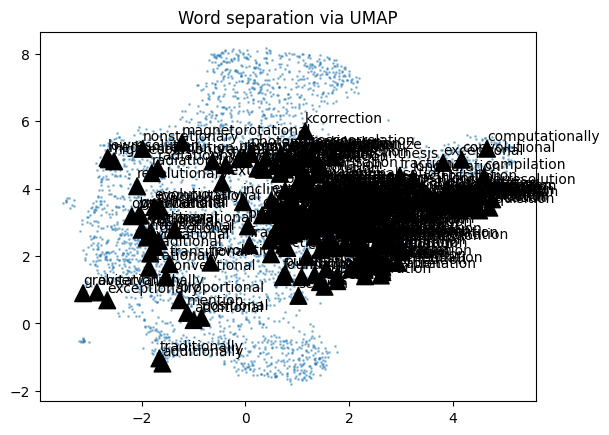

In [108]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

import umap
import matplotlib.pyplot as plt

embeddings = model.encode(vocabulary_limitCut)
print(np.shape(embeddings))
reducer = umap.UMAP(n_neighbors=50, min_dist=0.3, metric='euclidean')
proj = reducer.fit_transform(embeddings)

plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.4)
for i, word in enumerate(vocabulary_limitCut):
    if 'tion' not in word: continue
    print(proj[i,0], proj[i,1])
    plt.annotate(word, (proj[i, 0], proj[i, 1]), arrowprops=dict(facecolor='black', shrink=0.05))
    
plt.title("Word separation via UMAP")
plt.show()

clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.4, linkage='average', metric='cosine')
labels = clustering.fit_predict(embeddings)

# for word, label in zip(vocabulary_limitCut, labels):
#     print(f"{word}: cluster {label}")

# Extracting Keywords

In [ ]:
from keybert import KeyBERT
kw_model = KeyBERT()

def extract_keywords(text):
    keywords = kw_model.extract_keywords(text, stop_words='english', top_n=5)
    return [kw[0] for kw in keywords]


In [ ]:
# Run Cell Flag
RUN_CELL = False

if RUN_CELL:
    keywords_list = []
    for _ in tqdm.tqdm(ABSTRACT_LIST, desc='Abstract Text'):
        keywords = extract_keywords(_)
        keywords_list.append(keywords)


In [ ]:
# df['Keywords'] = keywords_list

In [ ]:
# from collections import Counter

# # Assuming you have a list of (year, abstract/title) pairs
# yearly_keywords = {}

# yearly_keywords = df.groupby(['Year', 'Month'])['Keywords'].apply(lambda x: x).reset_index()
# print(yearly_keywords, type(yearly_keywords))

# print(yearly_keywords.index)
# # # Count keyword frequencies per year
# # keyword_freqs = {year: Counter(keywords) for year, keywords in yearly_keywords.items()}

In [ ]:
# for YEAR in range(2010, 2026):
#     for MONTH in range(1,13):
#         print(YEAR, str(MONTH).zfill(2))
#         words = yearly_keywords[np.logical_and(yearly_keywords['Year'] == str(YEAR), \
#                                                yearly_keywords['Month'] == str(MONTH).zfill(2))]['Keywords'].values
#         print(words)
    

In [ ]:
dummy = []
print(keywords_list)
for _ in keywords_list:
    dummy = np.concatenate([dummy, _])
keywords_flat, keywords_count = np.unique(dummy, return_counts=True)
ORDERED = np.argsort(keywords_count)[::-1]
keywords_flat, keywords_count = keywords_flat[ORDERED], keywords_count[ORDERED]

In [ ]:
print(len(keywords_flat))
with open('keywords_list.txt', 'w') as f:
    for _ in keywords_flat:
        f.write(_)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(keywords_flat[:40], keywords_count[:40],)
plt.xticks(rotation=45, ha='right') 
fig.show()

In [ ]:
from gensim.models import Word2Vec
import gensim
import gensim.downloader
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt_tab')
import warnings

import json

with open("keyword_groups.json", "r") as f:
    categoryTable = json.load(f)

def invert_categoryTable(_categoryTable):

    _invertedCategories = {}
    for superCategory in _categoryTable.keys():
        print(f"{superCategory} --> {_categoryTable[superCategory]}")
        for __ in _categoryTable[superCategory]:
            print(f"Moving {__} --> {superCategory}")
            _invertedCategories[__.lower()] = superCategory
            
    return _invertedCategories

def get_SuperCategories(_keyword, _invertedCategories):
    print(_keyword)

    return _invertedCategories[_keyword]
    

invertedCategories = invert_categoryTable(categoryTable)



In [ ]:
print(sorted(invertedCategories.keys()))
superCategories = [get_SuperCategories(keyword, invertedCategories) for keyword in keywords_flat]